In [243]:
import pyspark
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, PCA
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean, avg, max
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import DataFrame
from pyspark.ml.feature import Imputer
import pandas as pd
from pyspark.sql.functions import col

In [244]:
spark = SparkSession.builder.appName('customer churn').getOrCreate()


In [245]:
class SmartEncoder():
    use_onehot = False
    use_std_scaler = False
    use_pca = False

    def __init__(self, df1, pred, use_oversampler, use_onehot, use_std_scaler, use_pca):
        print("Constructor of Class samrtencoder ")

        self.df1 = df1
        self.pred = pred
        self.use_oversampler = use_oversampler
        self.use_onehot = use_onehot
        self.use_std_scaler = use_std_scaler
        self.pca = use_pca

    @staticmethod
    def checkNulls(df):
        null_cols = {col: df.filter(df[col].isNull()).count() for col in df.columns}
        return null_cols

    @staticmethod
    def checkDuplicates(df):
        if df.count() > df.dropDuplicates().count():
            raise ValueError('Data has duplicates')

    def handlingMissingVal(self):

        #drop cols when the whole row is null
        df = self.df1.na.drop(how="all")
        #drop duplicates
        df = df.dropDuplicates()
        #Treating missing values
        cols_to_drop = [x for x in df.columns if df.filter(df[x].isNull()).count() > 0]
        if len(cols_to_drop) != 0:
            dff = df.select(cols_to_drop)
            continuousCols = [item[0] for item in dff.dtypes if item[1] != 'string']
            imputer = Imputer(inputCols=continuousCols, outputCols=continuousCols).setStrategy("mean")
            model = imputer.fit(df)
            imputed_data = model.transform(df)

        else:
            imputed_data = df

        return imputed_data

    def indexString(self):

        imputed = self.handlingMissingVal()
        if self.use_oversampler == True:
            imputed = self.oversmaple(imputed)

        #index the string to numeric
        self.stringCols = [item[0] for item in imputed.dtypes if item[1] == 'string']
        if len(self.stringCols) != 0:
            outputs = [y + "_encoded" for y in self.stringCols]
            stringIndexer = StringIndexer(inputCols=self.stringCols, outputCols=outputs)
            model = stringIndexer.fit(imputed)
            result = model.transform(imputed)
    
            encoded = result.drop(*self.stringCols)

            if self.use_onehot == True:
                #converting categorical attributes into a binary vector
                encoder = OneHotEncoder(dropLast=False, inputCols=outputs,
                                        outputCols=[x + "_vec" for x in self.stringCols])
                encoded2 = encoder.fit(encoded).transform(encoded)

                encoded = encoded2.drop(*outputs)
            encoded = encoded.withColumnRenamed(self.pred + '_encoded', self.pred)
            encoded = encoded.withColumnRenamed(self.pred + '_vec', self.pred)
        else:
            encoded = imputed

        return encoded

    def oversmaple(self, df):
        # example of random oversampling to balance the class distribution
        from collections import Counter
        from imblearn.over_sampling import RandomOverSampler
        dfp = df.toPandas()
        # define oversampling strategy
        oversample = RandomOverSampler()
        # fit and apply the transform
        data, y = oversample.fit_resample(dfp.loc[:, dfp.columns != self.pred], dfp[self.pred])
        data[self.pred] = y
        df_sample = spark.createDataFrame(data)
        # summarize class distribution
        print(Counter(y))

        return df_sample

    def dataAssembler(self, drops):
        # VectorAssembler - tranform features into a feature vector column
        encoded = self.indexString()
        encoded = encoded.drop(*drops)
        assembler = VectorAssembler(inputCols=encoded.drop(self.pred).columns, outputCol='features')
        df_Assembled = assembler.transform(encoded)

        if self.use_std_scaler == True:
            # standardize the dataframe to ensure that all the variables are around the same scale
            scale = StandardScaler(inputCol='features', outputCol='standardized')
            df_scale = scale.fit(df_Assembled)
            df_Assembled = df_scale.transform(df_Assembled)

        if self.pca == True:
            pca = PCA(k=3, inputCol=df_Assembled.columns[-1])
            pca.setOutputCol("pca_features")

            model = pca.fit(df_Assembled)
            df_Assembled = model.transform(df_Assembled)

        return df_Assembled



In [246]:
df = spark.read.csv('/Users/aminaterbachi/Downloads/customer_churn.csv', header=True, inferSchema=True)


In [247]:
df.count()


900

In [248]:
df.show(5)


+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|             Company|Churn|
+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|2013-08-30 07:00:40|10265 Elizabeth M...|          Harvey LLC|    1|
|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|2013-08-13 00:38:46|6157 Frank Garden...|          Wilson PLC|    1|
|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|2016-06-29 06:20:07|1331 Keith Court ...|Miller, Johnson a...|    1|
|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|2014-04-22 12:43:12|13120 Daniel Moun...|           Smith Inc|    1|
|  Cynthia Norton|37.0|    

In [249]:
df.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)


In [250]:
df.describe().show()


+-------+-------------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+--------------------+-------------------+
|summary|        Names|              Age|   Total_Purchase|   Account_Manager|            Years|         Num_Sites|            Location|             Company|              Churn|
+-------+-------------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+--------------------+-------------------+
|  count|          900|              900|              900|               900|              900|               900|                 900|                 900|                900|
|   mean|         NULL|41.81666666666667|10062.82403333334|0.4811111111111111| 5.27315555555555| 8.587777777777777|                NULL|                NULL|0.16666666666666666|
| stddev|         NULL|6.127560416916251|2408.644531858096|0.4999208935073339|1.274449013194616|1.764835592035

In [251]:
SmartEncoder.checkNulls(df)


{'Names': 0,
 'Age': 0,
 'Total_Purchase': 0,
 'Account_Manager': 0,
 'Years': 0,
 'Num_Sites': 0,
 'Onboard_date': 0,
 'Location': 0,
 'Company': 0,
 'Churn': 0}

In [252]:
df.select('Onboard_date').distinct().count()


900

In [253]:
df = df.drop('Onboard_date')


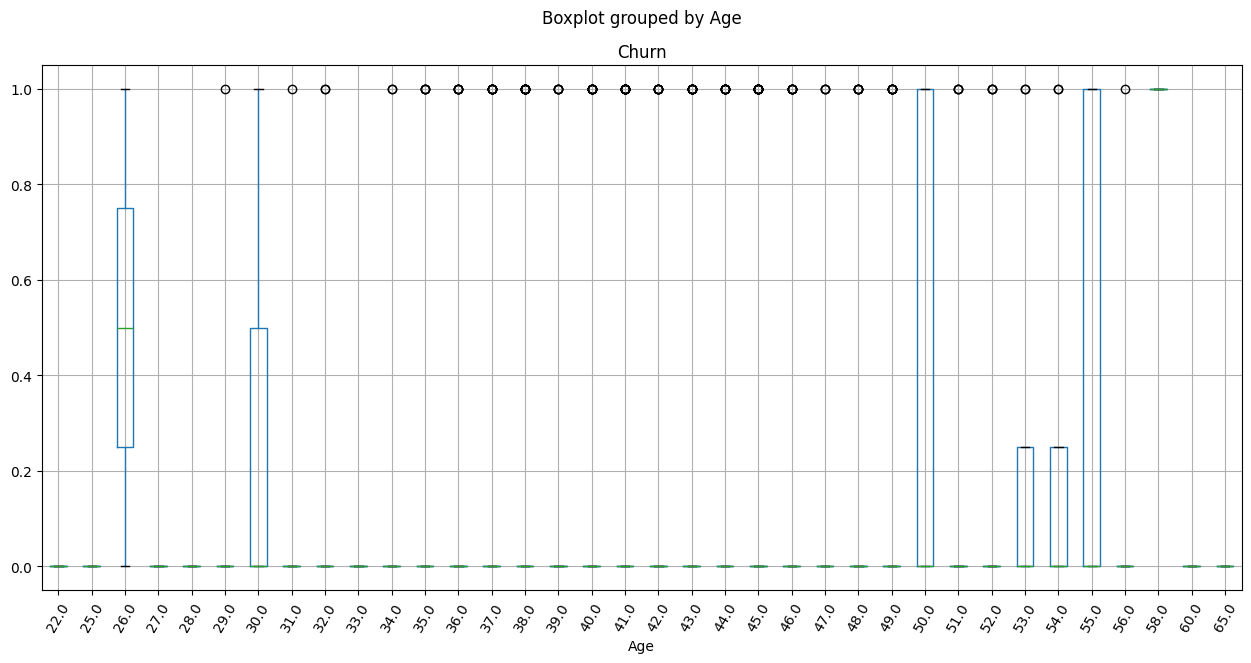

In [254]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 7))
df.toPandas().boxplot('Churn', 'Age', rot=60, ax=ax)
# Show the plot
plt.show()

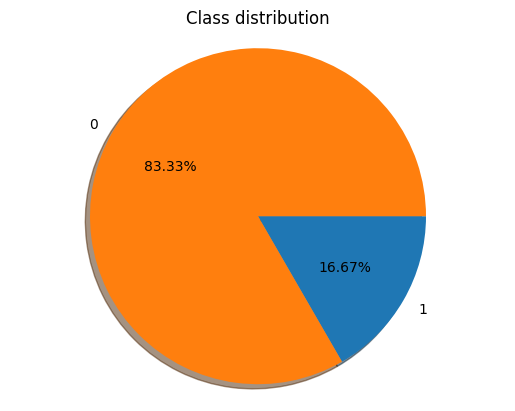

In [255]:
# Class (Target) Distribution
class_dis = df.groupBy("Churn").count().toPandas()
class_occur = class_dis['count']
#class_names = ['churn','Not churn']
class_names = class_dis['Churn']
fig, ax = plt.subplots()
ax.pie(class_occur, labels=class_names, autopct='%1.2f%%',
       shadow=True, startangle=0, counterclock=False)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Class distribution')
plt.show()

In [256]:
obj = SmartEncoder(df, 'Churn', True, True, True, False)


Constructor of Class samrtencoder 


In [257]:
dfr = obj.indexString()
dfr.count()

/Users/aminaterbachi/Documents/PycharmProjects/BigDataProject/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


Counter({0: 750, 1: 750})


1500

In [258]:
dfr.columns


['Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Churn',
 'Names_vec',
 'Location_vec',
 'Company_vec']

In [263]:
dfr.groupBy('Churn').count().show()


+-----+-----+
|Churn|count|
+-----+-----+
|    0|  750|
|    1|  750|
+-----+-----+


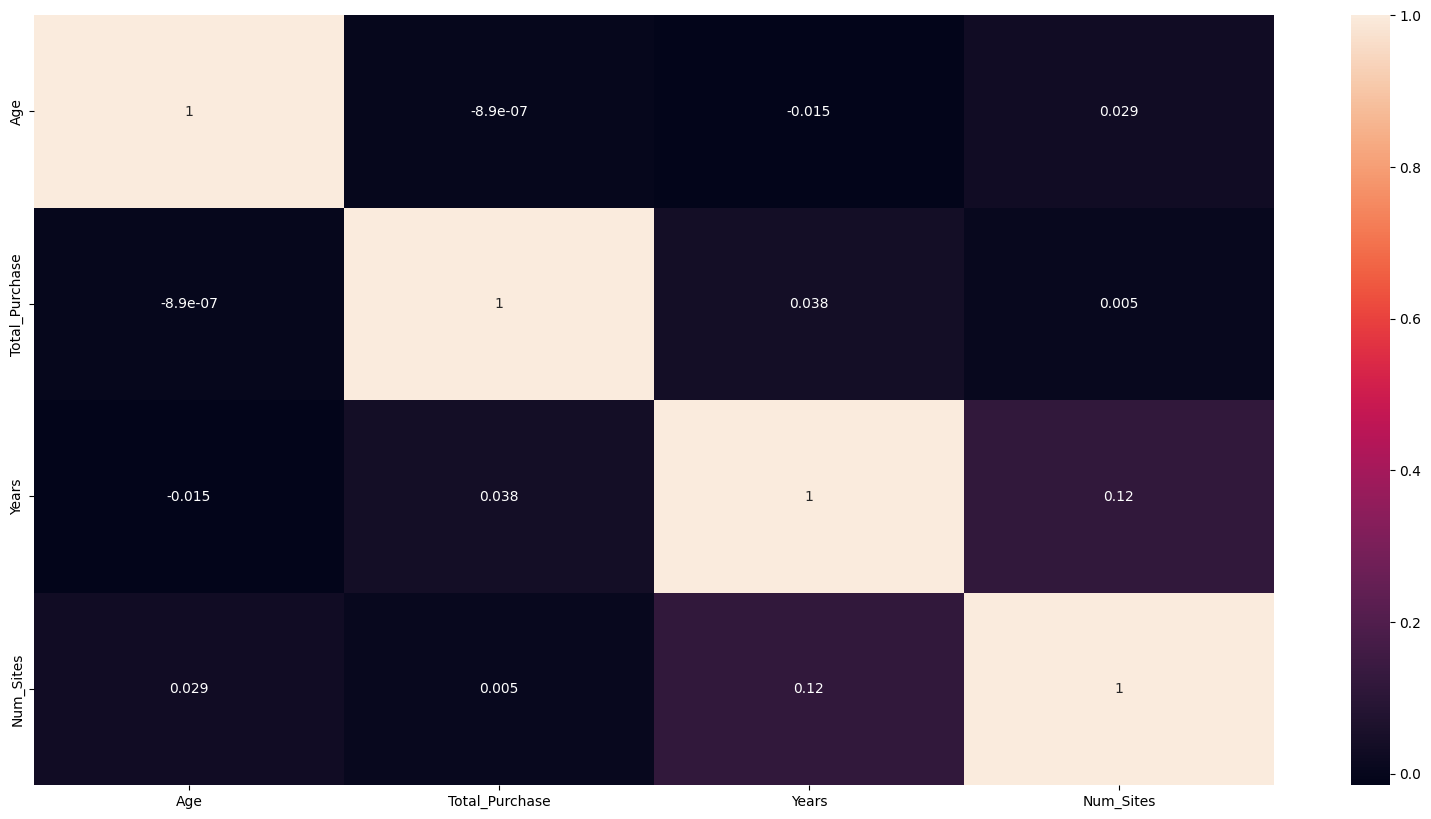

In [267]:
from pyspark.sql.types import IntegerType, DoubleType
import seaborn as sns

# Assuming 'dfr' is your Spark DataFrame
numeric_cols = [field.name for field in dfr.schema.fields if isinstance(field.dataType, (IntegerType, DoubleType))]
numeric_data = dfr.select(numeric_cols).toPandas()

plt.figure(figsize=(20, 10))
sns.heatmap(numeric_data.corr(), annot=True)
plt.show()

In [268]:
df_fin = obj.dataAssembler('')

/Users/aminaterbachi/Documents/PycharmProjects/BigDataProject/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


Counter({0: 750, 1: 750})


In [269]:
df_fin.columns


['Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Churn',
 'Names_vec',
 'Location_vec',
 'Company_vec',
 'features',
 'standardized']

In [270]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator


class ClassificationEval():

    def __init__(self, pred, final_df):
        print("Constructor of Class for classification evaluation")
        self.final_df = final_df
        self.pred = pred
        self.accuresult = {}
        self.rocresult = {}

    def run_on_model(self, model, featureCol):
        trainDF, testDF = self.final_df.randomSplit([0.7, 0.3], seed=42)
        if model == 'lr':
            lr = LogisticRegression(labelCol=self.pred, featuresCol=featureCol, maxIter=40)
            modellr = lr.fit(trainDF)
            self.predlr = modellr.transform(testDF)
            return self.predlr
        elif model == 'rf':
            rf = RandomForestClassifier(labelCol=self.pred, featuresCol=featureCol, numTrees=100, maxDepth=3)
            modelRf = rf.fit(trainDF)
            self.predrf = modelRf.transform(testDF)
            return self.predrf
        elif model == 'gb':
            gb = GBTClassifier(labelCol=self.pred, featuresCol=featureCol, maxIter=75, maxDepth=3)
            modelgb = gb.fit(trainDF)
            self.predgb = modelgb.transform(testDF)
            return self.predgb
        elif model == 'lsvc':
            lsvc = LinearSVC(labelCol=self.pred, featuresCol=featureCol, maxIter=10, regParam=0.1)
            lsvcModel = lsvc.fit(trainDF)
            self.predsvc = lsvcModel.transform(testDF)
            return self.predsvc
        else:
            raise ValueError('invalid model')

    def genMetrics(self, model, featureCol):

        pred_test = self.run_on_model(model, featureCol)
        binEval = BinaryClassificationEvaluator(labelCol=self.pred)
        evaluator = MulticlassClassificationEvaluator(labelCol=self.pred, predictionCol="prediction")
        self.accuresult[model] = evaluator.evaluate(pred_test, {evaluator.metricName: "accuracy"})
        self.rocresult[model] = binEval.evaluate(pred_test, {binEval.metricName: "areaUnderROC"})

    def run_all_model(self, featureCol):
        models = ['lr', 'rf', 'gb', 'lsvc']
        for model in models:
            self.genMetrics(model, featureCol)
        print("Accuracy =", self.accuresult)
        print("roc =", self.rocresult)
        return self.accuresult, self.rocresult

    def compareModel(self):
        best_v = 0
        best_k = None
        for k, v in self.accuresult.items():
            if best_v < v:
                best_v = v
                best_k = k
        return best_k, best_v


In [271]:
obj2 = ClassificationEval('Churn', df_fin)


Constructor of Class for classification evaluation


In [272]:
accu, roc = obj2.run_all_model("features")


23/11/18 12:57:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/11/18 12:57:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Accuracy = {'lr': 0.8869936034115139, 'rf': 0.8230277185501066, 'gb': 0.8912579957356077, 'lsvc': 0.8912579957356077}
roc = {'lr': 0.9999272515640913, 'rf': 0.8806198166739416, 'gb': 0.9431107231194529, 'lsvc': 0.9999272515640913}


In [273]:
obj2.compareModel()

('gb', 0.8912579957356077)

In [274]:
trainDF, testDF = df_fin.randomSplit([0.7, 0.3], seed=42)

In [275]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="Churn", featuresCol="features", maxIter=10)
gbtModel = gbt.fit(trainDF)
gbtPreds = gbtModel.transform(testDF)


In [276]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

gbtEval = BinaryClassificationEvaluator(labelCol="Churn")
gbtROC = gbtEval.evaluate(gbtPreds, {gbtEval.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(gbtROC))


Test Area Under ROC: 0.941492070420486


In [277]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=gbtEval, numFolds=5)

# Run cross validations.  
# This can take some minutes since it is training over 20 trees!
cvModel = cv.fit(trainDF)
cvPreds = cvModel.transform(testDF)
gbtEval.evaluate(cvPreds)

0.9436654299432562

In [280]:
from pyspark.ml import Pipeline

# Create a Pipeline with your model and any preprocessing stages
pipeline = Pipeline(stages=[gbt])

# Fit the pipeline on your data
model = pipeline.fit(df_fin)

# Save the model to a path
model.save("/Users/aminaterbachi/PycharmProjects/scientificProject/models/churn_prediction_model")